In [ ]:
import scipy.io
import matplotlib.pyplot as plt
import os
import glob
from scipy.stats import entropy
import sys
import matplotlib.pyplot as plt
import pywt
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
from scipy.signal import welch
from scipy.interpolate import interp1d

In [ ]:
"""Mounting Google Drive"""
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def find_mat_files(root_dir):
    mat_files = []
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.mat'):
                mat_files.append(os.path.join(dirpath, filename))
    return mat_files

# file_path = r'/content/drive/MyDrive/ASD/'
file_path = r'/content/drive/MyDrive/TD/'

mat_files = find_mat_files(file_path)

In [ ]:
# Function to perform window slicing on the EEG signal
def window_slice(signal, window_size, overlap):
    """
    Perform window slicing on the signal.

    Parameters:
    - signal: The input signal (1D array).
    - window_size: The size of each window.
    - overlap: The overlap between consecutive windows.

    Returns:
    - windows: 2D array containing sliced windows.
    """
    windows = []
    for i in range(0, len(signal) - window_size + 1, window_size - overlap):
        window = signal[i:i + window_size]
        windows.append(window)
    return np.array(windows)

In [ ]:
# Function to extract time-domain features from each window
def extract_time_domain_features(window):
    features = [
        np.mean(window),
        np.std(window),
        np.median(window),
        np.max(window) - np.min(window),
        np.mean((window - np.mean(window)) ** 3) / np.std(window) ** 3,  # Skewness
        np.mean((window - np.mean(window)) ** 4) / np.var(window) ** 2 - 3,  # Kurtosis
    ]
    return features

In [ ]:
# Function to extract frequency band power from each window
def extract_frequency_bands(window, sampling_rate):
    f, psd = welch(window, fs=sampling_rate, nperseg=len(window))

    # Define frequency bands (adjust as needed)
    delta_band = (0.5, 4)
    theta_band = (4, 8)
    alpha_band = (8, 13)
    beta_band = (13, 30)
    gamma_band = (30, 40)

    # Interpolate PSD to ensure even frequency spacing
    f_interp = np.linspace(f.min(), f.max(), len(f))
    psd_interp = interp1d(f, psd, kind='linear', fill_value='extrapolate')(f_interp)

    # Calculate index range for each frequency band
    delta_indices = np.where((f_interp >= delta_band[0]) & (f_interp <= delta_band[1]))[0]
    theta_indices = np.where((f_interp >= theta_band[0]) & (f_interp <= theta_band[1]))[0]
    alpha_indices = np.where((f_interp >= alpha_band[0]) & (f_interp <= alpha_band[1]))[0]
    beta_indices = np.where((f_interp >= beta_band[0]) & (f_interp <= beta_band[1]))[0]
    gamma_indices = np.where((f_interp >= gamma_band[0]) & (f_interp <= gamma_band[1]))[0]

    # Extract power in each frequency band
    delta_power = np.trapz(psd_interp[delta_indices], dx=f_interp[1] - f_interp[0])
    theta_power = np.trapz(psd_interp[theta_indices], dx=f_interp[1] - f_interp[0])
    alpha_power = np.trapz(psd_interp[alpha_indices], dx=f_interp[1] - f_interp[0])
    beta_power = np.trapz(psd_interp[beta_indices], dx=f_interp[1] - f_interp[0])
    gamma_power = np.trapz(psd_interp[gamma_indices], dx=f_interp[1] - f_interp[0])

    return {
        'Delta': delta_power,
        'Theta': theta_power,
        'Alpha': alpha_power,
        'Beta': beta_power,
        'Gamma': gamma_power
    }

In [ ]:
mat_file_path = mat_files[2]
mat_data = scipy.io.loadmat(mat_file_path)
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Scr_Segment1', 'Scr_Segment2', 'Scr_Segment3', 'Scr_Segment4', 'Scr_Segment5', 'Scr_Segment6', 'Scr_Segment7', 'Scr_Segment8', 'Scr_Segment9', 'Scr_Segment10', 'Scr_Segment11', 'Scr_Segment12', 'Scr_Segment13', 'Scr_Segment14', 'Scr_Segment15', 'Scr_Segment16', 'Scr_Segment17', 'Scr_Segment18', 'Scr_Segment19', 'Scr_Segment20', 'Scr_Segment21', 'Scr_Segment22', 'Scr_Segment23', 'Scr_Segment24', 'Scr_Segment25', 'Scr_Segment26', 'Scr_Segment27', 'Scr_Segment28', 'Scr_Segment29', 'Scr_Segment30', 'Scr_Segment31', 'Scr_Segment32', 'Scr_Segment33', 'Scr_Segment34', 'Scr_Segment35', 'Scr_Segment36', 'Scr_Segment37', 'Scr_Segment38', 'Scr_Segment39', 'Scr_Segment40', 'Scr_Segment41', 'Scr_Segment42', 'Scr_Segment43', 'Scr_Segment44', 'Scr_Segment45', 'Fix_Segment1', 'Fix_Segment2', 'Fix_Segment3', 'Fix_Segment4', 'Fix_Segment5', 'Fix_Segment6', 'Fix_Segment7', 'Fix_Segment8', 'Fix_Segment9', 'Fix_Segment10', 'Fix_Segment11', 'Fix_Segmen

shape of bio segment 1 (125, 600)


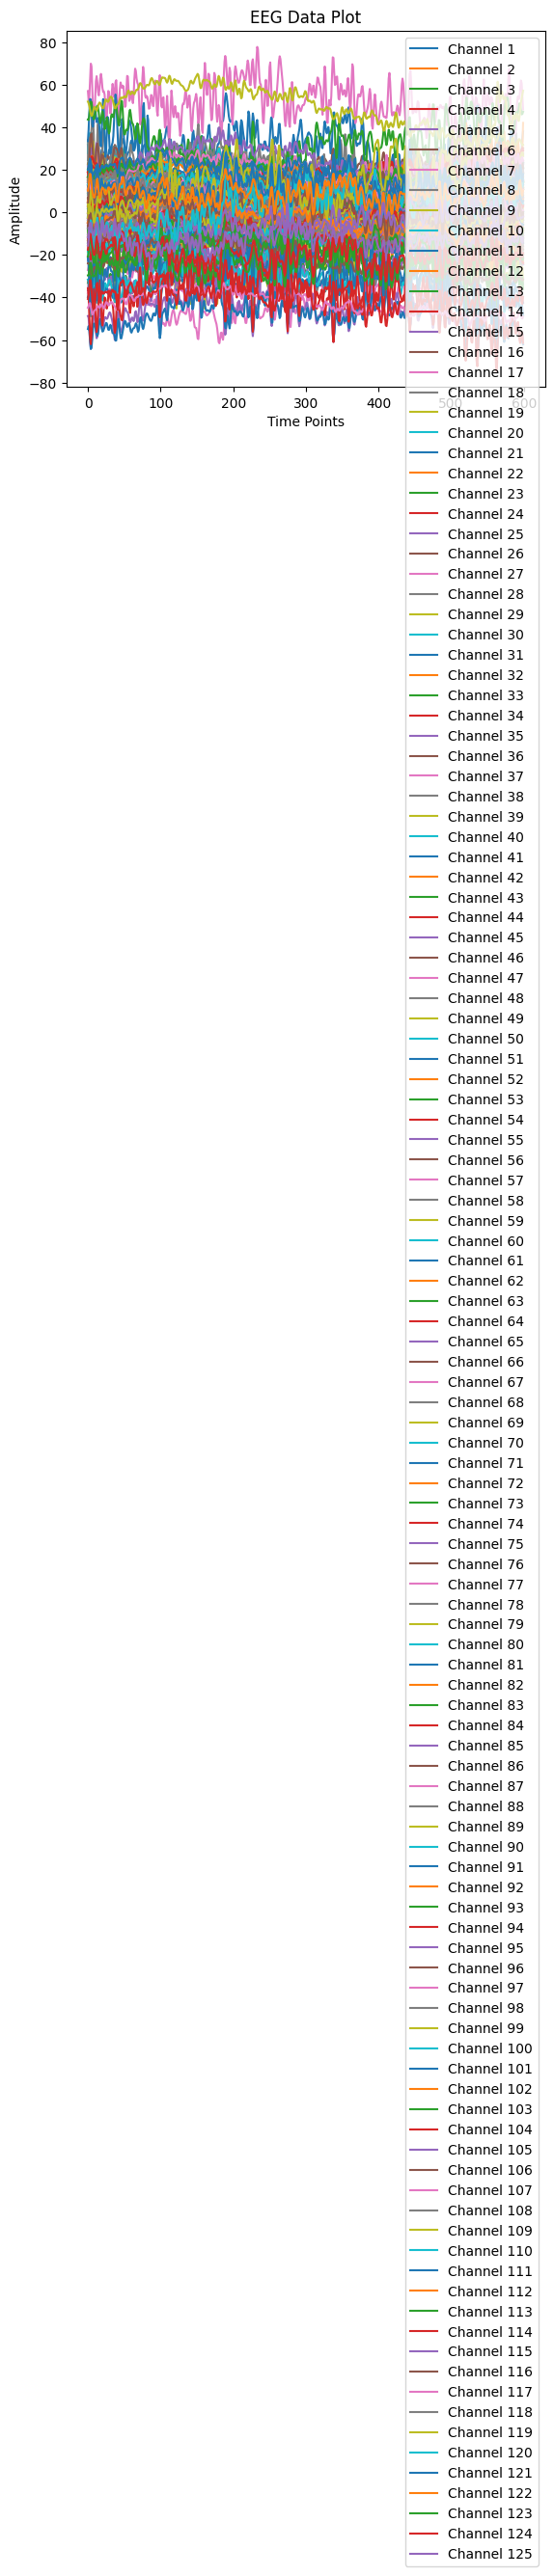

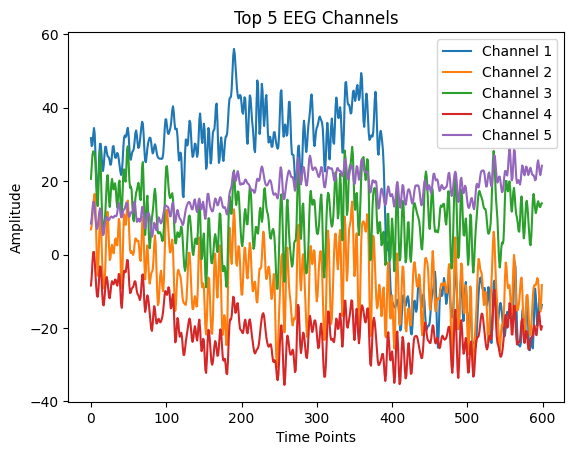

maximum level is 4


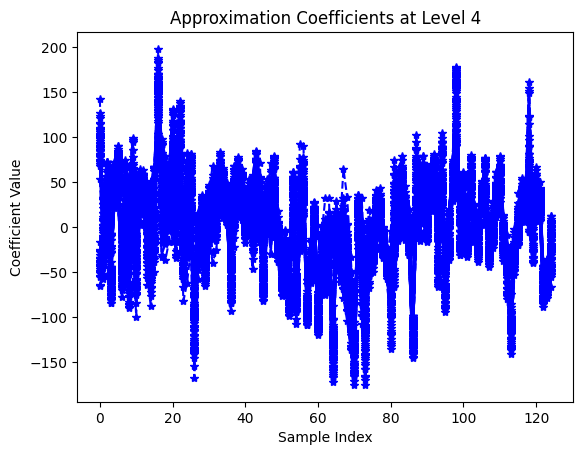

(125, 600)


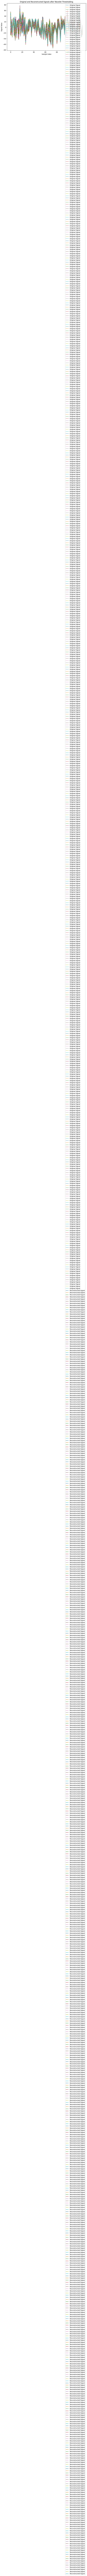

In [ ]:
# for mat_file_path in mat_files[0:1]:
for mat_file_path in mat_files[2:3]:
  mat_data = scipy.io.loadmat(mat_file_path)
  try:
    eeg_data = mat_data['Bio_Segment4']
  except:
    try:
      eeg_data = mat_data['Known_Segment4']
    except:
      eeg_data = mat_data['EO_Segment4']

  print("shape of bio segment 1",eeg_data.shape)

  # Plot EEG channels
  num_channels, num_time_points = eeg_data.shape

  for channel in range(num_channels):
      plt.plot(eeg_data[channel, :], label=f'Channel {channel + 1}')

  plt.title('EEG Data Plot')
  plt.xlabel('Time Points')
  plt.ylabel('Amplitude')
  plt.legend()
  plt.show()

  # Plot the top 5 EEG channels
  num_channels, num_time_points = eeg_data.shape
  num_channels_to_plot = min(5, num_channels)  # Choose the top 5 channels or all channels if less than 5

  for channel in range(num_channels_to_plot):
      plt.plot(eeg_data[channel, :], label=f'Channel {channel + 1}')

  plt.title('Top 5 EEG Channels')
  plt.xlabel('Time Points')
  plt.ylabel('Amplitude')
  plt.legend()
  plt.show()


  w = pywt.Wavelet('db4')
  maxlev = pywt.dwt_max_level(len(eeg_data), w.dec_len)
  print("maximum level is " + str(maxlev))
  threshold = 0.04
  coeffs = pywt.wavedec(eeg_data, 'db4', level=3)
  # Extract the approximation coefficients at the chosen level
  cA = coeffs[0]

  # Plot the approximation coefficients
  plt.plot(cA, '--*b')
  plt.title(f'Approximation Coefficients at Level {maxlev}')
  plt.xlabel('Sample Index')
  plt.ylabel('Coefficient Value')
  plt.show()

  # Threshold the wavelet coefficients
  for i in range(1, len(coeffs)):  # Skip the approximation coefficients
      coeffs[i] = pywt.threshold(coeffs[i], threshold * np.max(np.abs(coeffs[i])), mode='soft')

  # Reconstruct the signal using the thresholded coefficients
  reconstructed_signal = pywt.waverec(coeffs, 'db4')
  print(reconstructed_signal.shape)

  # Plot the original and reconstructed signals
  plt.figure(figsize=(10, 6))
  plt.plot(eeg_data, label='Original Signal', alpha=0.7)
  plt.plot(reconstructed_signal, label='Reconstructed Signal', linestyle='--', linewidth=2)
  plt.title('Original and Reconstructed Signals after Wavelet Thresholding')
  plt.xlabel('Sample Index')
  plt.ylabel('Signal Value')
  plt.legend()
  plt.show()


  # Parameters for window slicing
  window_size = 100  # Size of each window
  overlap = 50  # Overlap between consecutive windows

In [ ]:
eeg_data_td = eeg_data

In [ ]:
def find_mat_files(root_dir):
    mat_files = []
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.mat'):
                mat_files.append(os.path.join(dirpath, filename))
    return mat_files

file_path = r'/content/drive/MyDrive/ASD/'
# file_path = r'/content/drive/MyDrive/TD/'

mat_files = find_mat_files(file_path)

In [ ]:
mat_file_path = mat_files[0]
mat_data = scipy.io.loadmat(mat_file_path)
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Fix_Segment1', 'Fix_Segment2', 'Fix_Segment3', 'Fix_Segment4', 'Fix_Segment5', 'Fix_Segment6', 'Fix_Segment7', 'Fix_Segment8', 'Fix_Segment9', 'Fix_Segment10', 'Fix_Segment11', 'Fix_Segment12', 'Fix_Segment13', 'Fix_Segment14', 'Fix_Segment15', 'Fix_Segment16', 'Fix_Segment17', 'Fix_Segment18', 'Fix_Segment19', 'Fix_Segment20', 'Fix_Segment21', 'Fix_Segment22', 'Fix_Segment23', 'Fix_Segment24', 'Fix_Segment25', 'Fix_Segment26', 'Fix_Segment27', 'Fix_Segment28', 'Fix_Segment29', 'Fix_Segment30', 'Fix_Segment31', 'Fix_Segment32', 'Fix_Segment33', 'Fix_Segment34', 'Fix_Segment35', 'Fix_Segment36', 'Fix_Segment37', 'Fix_Segment38', 'Fix_Segment39', 'Fix_Segment40', 'Fix_Segment41', 'Fix_Segment42', 'Fix_Segment43', 'Fix_Segment44', 'Fix_Segment45', 'Fix_Segment46', 'Fix_Segment47', 'Fix_Segment48', 'Fix_Segment49', 'Fix_Segment50', 'Fix_Segment51', 'Fix_Segment52', 'Fix_Segment53', 'Fix_Segment54', 'Fix_Segment55', 'Fix_Segment56', 'F

shape of bio segment 1 (125, 600)


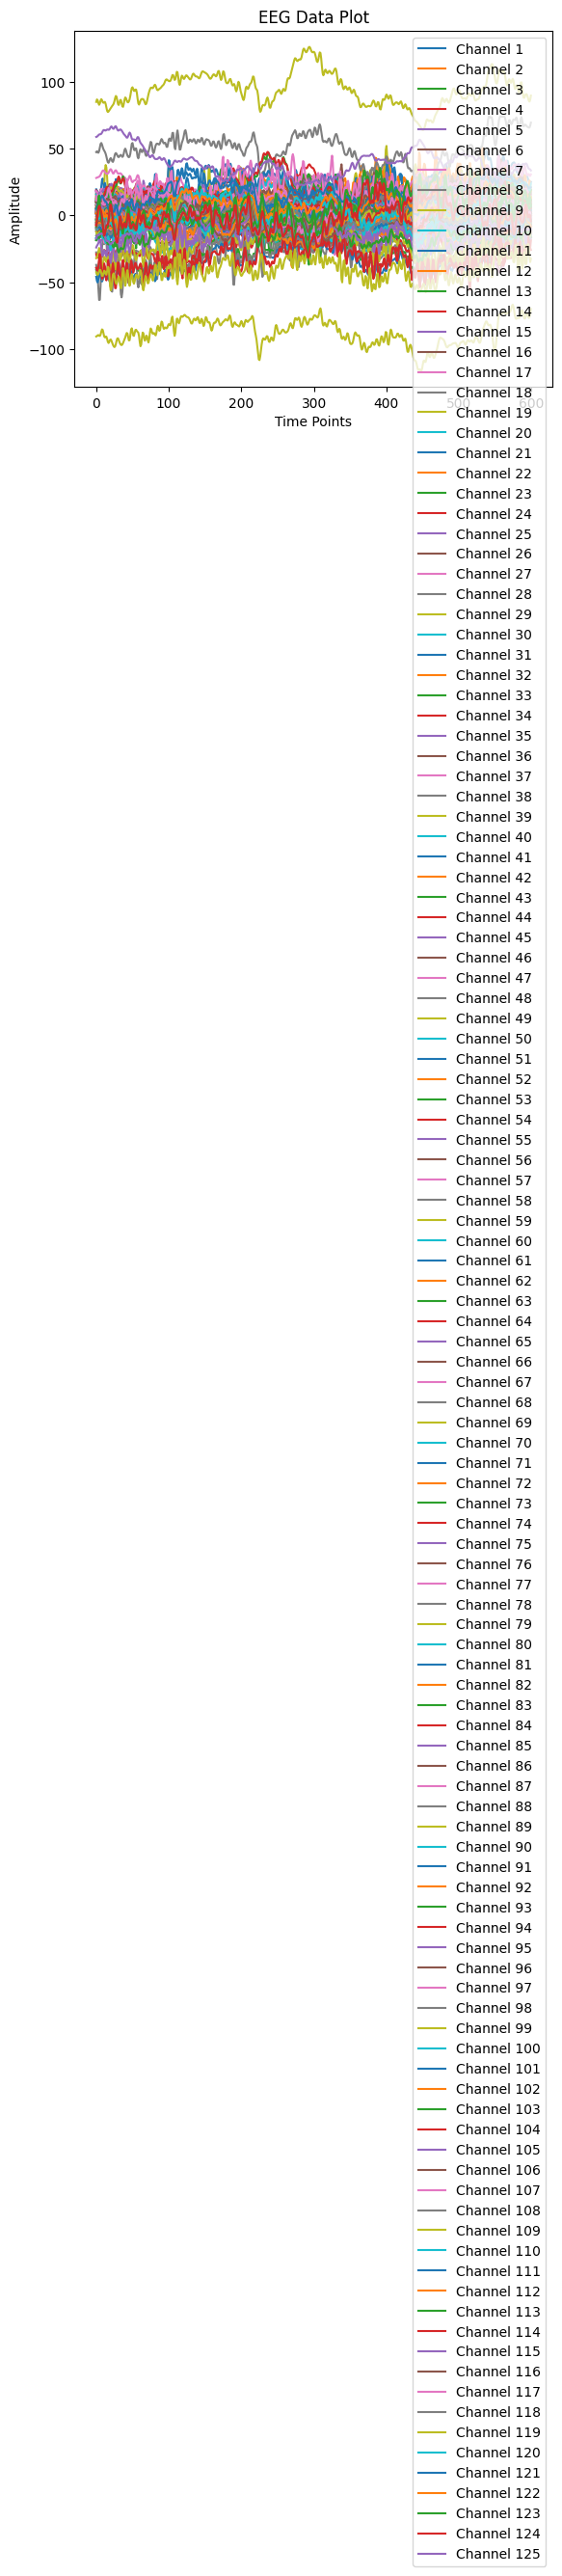

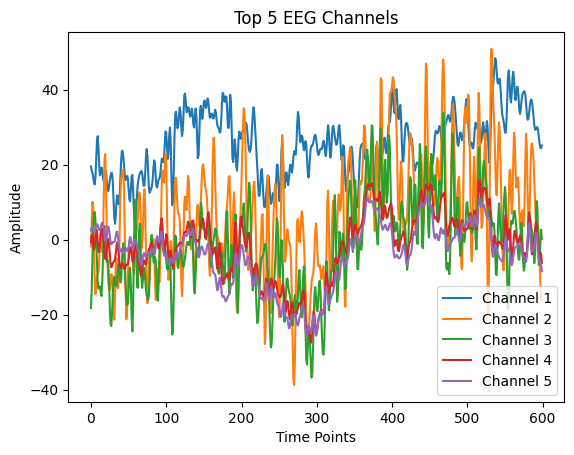

maximum level is 4


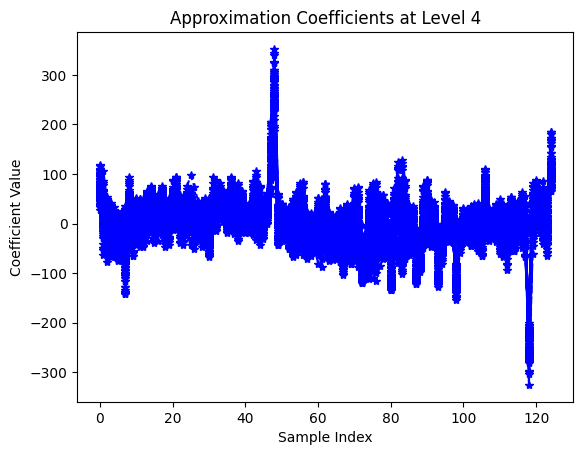

(125, 600)


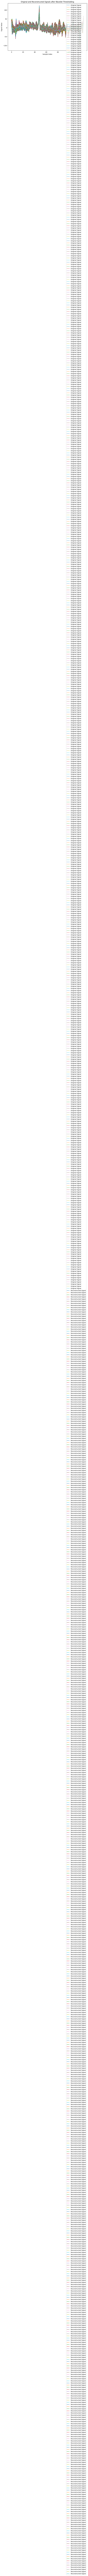

In [ ]:
# for mat_file_path in mat_files[1:2]:
for mat_file_path in mat_files[0:1]:
  mat_data = scipy.io.loadmat(mat_file_path)
  try:
    eeg_data = mat_data['Bio_Segment4']
  except:
    try:
      eeg_data = mat_data['Known_Segment4']
    except:
      eeg_data = mat_data['EO_Segment4']

  print("shape of bio segment 1",eeg_data.shape)

  # Plot EEG channels
  num_channels, num_time_points = eeg_data.shape

  for channel in range(num_channels):
      plt.plot(eeg_data[channel, :], label=f'Channel {channel + 1}')

  plt.title('EEG Data Plot')
  plt.xlabel('Time Points')
  plt.ylabel('Amplitude')
  plt.legend()
  plt.show()

  # Plot the top 5 EEG channels
  num_channels, num_time_points = eeg_data.shape
  num_channels_to_plot = min(5, num_channels)  # Choose the top 5 channels or all channels if less than 5

  for channel in range(num_channels_to_plot):
      plt.plot(eeg_data[channel, :], label=f'Channel {channel + 1}')

  plt.title('Top 5 EEG Channels')
  plt.xlabel('Time Points')
  plt.ylabel('Amplitude')
  plt.legend()
  plt.show()


  w = pywt.Wavelet('db4')
  maxlev = pywt.dwt_max_level(len(eeg_data), w.dec_len)
  print("maximum level is " + str(maxlev))
  threshold = 0.04
  coeffs = pywt.wavedec(eeg_data, 'db4', level=3)
  # Extract the approximation coefficients at the chosen level
  cA = coeffs[0]

  plt.plot(cA, '--*b')
  plt.title(f'Approximation Coefficients at Level {maxlev}')
  plt.xlabel('Sample Index')
  plt.ylabel('Coefficient Value')
  plt.show()

  # Threshold the wavelet coefficients
  for i in range(1, len(coeffs)):  # Skip the approximation coefficients
      coeffs[i] = pywt.threshold(coeffs[i], threshold * np.max(np.abs(coeffs[i])), mode='soft')

  # Reconstruct the signal using the thresholded coefficients
  reconstructed_signal = pywt.waverec(coeffs, 'db4')
  print(reconstructed_signal.shape)

  # Plot the original and reconstructed signals
  plt.figure(figsize=(10, 6))
  plt.plot(eeg_data, label='Original Signal', alpha=0.7)
  plt.plot(reconstructed_signal, label='Reconstructed Signal', linestyle='--', linewidth=2)
  plt.title('Original and Reconstructed Signals after Wavelet Thresholding')
  plt.xlabel('Sample Index')
  plt.ylabel('Signal Value')
  plt.legend()
  plt.show()


  # Parameters for window slicing
  window_size = 100  # Size of each window
  overlap = 50  # Overlap between consecutive windows

In [ ]:
eeg_data_asd = eeg_data

In [ ]:
import numpy as np
from sklearn.feature_selection import mutual_info_classif

# Transpose the arrays to shape (samples, channels)
eeg_data_asd = eeg_data_asd.T
eeg_data_td = eeg_data_td.T

# Create binary grouping variable: 0 for ASD, 1 for TD
labels_asd = np.zeros(eeg_data_asd.shape[0])
labels_td = np.ones(eeg_data_td.shape[0])

# Combine ASD and TD data
combined_data = np.vstack((eeg_data_asd, eeg_data_td))
combined_labels = np.hstack((labels_asd, labels_td))

# Calculate mutual information between each channel and the target variable (ASD or TD)
mi_combined = mutual_info_classif(combined_data, combined_labels)

# Find the indices of the channels with the highest mutual information
top_channels_indices = np.argsort(mi_combined)[-2:]

# Extract the data for the top two channels from each array
top_channels_asd = eeg_data_asd[:, top_channels_indices]
top_channels_td = eeg_data_td[:, top_channels_indices]

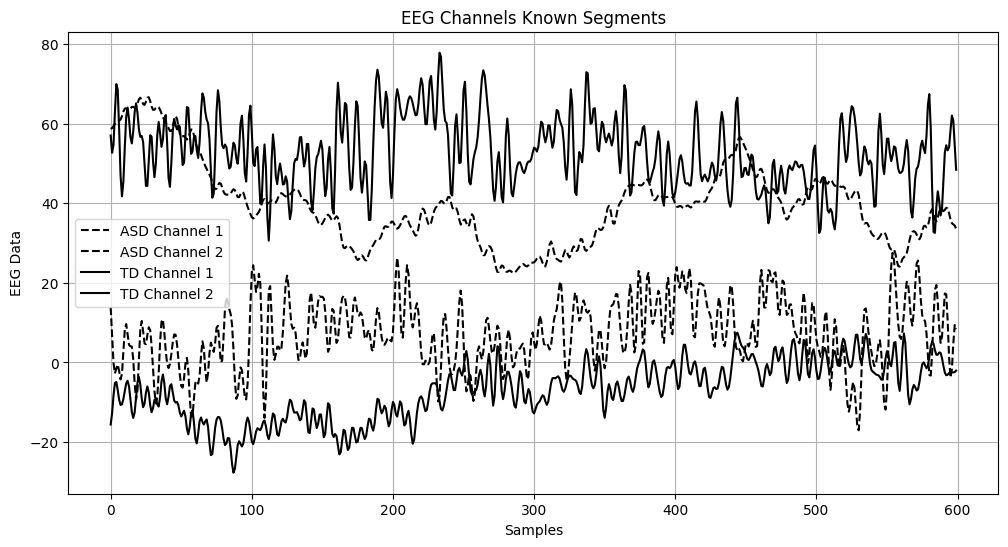

In [ ]:
plt.figure(figsize=(12, 6))

# Plot ASD channels
plt.plot(top_channels_asd[:, 0], color='black', linestyle='--', label='ASD Channel 1')
plt.plot(top_channels_asd[:, 1], color='black', linestyle='--', label='ASD Channel 2')

# Plot TD channels
plt.plot(top_channels_td[:, 0], color='black', linestyle='-', label='TD Channel 1')
plt.plot(top_channels_td[:, 1], color='black', linestyle='-', label='TD Channel 2')

plt.title('EEG Channels Known Segments')
plt.xlabel('Samples')
plt.ylabel('EEG Data')
plt.legend()
plt.grid(True)

# Save the plot as PDF
plt.savefig('eeg_bio_comparison.pdf', format='pdf')

# Save the plot as EPS
plt.savefig('eeg_bio_comparison.eps', format='eps')

plt.show()

In [ ]:
# for mat_file_path in mat_files[1:2]:
eeg_data_asd = []

for mat_file_path in mat_files[0:4]:
  mat_data = scipy.io.loadmat(mat_file_path)
  try:
    eeg_data = mat_data['Bio_Segment4']
  except:
    try:
      eeg_data = mat_data['Known_Segment4']
    except:
      eeg_data = mat_data['EO_Segment4']
  eeg_data_asd.append(eeg_data)

In [ ]:
mat_file_path = mat_files[4]
mat_data = scipy.io.loadmat(mat_file_path)
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Unknown_Segment1', 'Unknown_Segment2', 'Unknown_Segment3', 'Unknown_Segment4', 'Unknown_Segment5', 'Unknown_Segment6', 'Unknown_Segment7', 'Unknown_Segment8', 'Unknown_Segment9', 'Unknown_Segment10', 'Unknown_Segment11', 'Unknown_Segment12', 'Unknown_Segment13', 'Unknown_Segment14', 'Unknown_Segment15', 'Unknown_Segment16', 'Unknown_Segment17', 'Unknown_Segment18', 'Unknown_Segment19', 'Unknown_Segment20', 'Unknown_Segment21', 'Unknown_Segment22', 'Unknown_Segment23', 'Unknown_Segment24', 'Unknown_Segment25', 'Unknown_Segment26', 'Unknown_Segment27', 'Unknown_Segment28', 'Unknown_Segment29', 'Unknown_Segment30', 'Unknown_Segment31', 'Unknown_Segment32', 'Unknown_Segment33', 'Unknown_Segment34', 'Unknown_Segment35', 'Unknown_Segment36', 'Unknown_Segment37', 'Unknown_Segment38', 'Unknown_Segment39', 'Unknown_Segment40', 'Unknown_Segment41', 'Known_Segment1', 'Known_Segment2', 'Known_Segment3', 'Known_Segment4', 'Known_Segment5', 'Kn

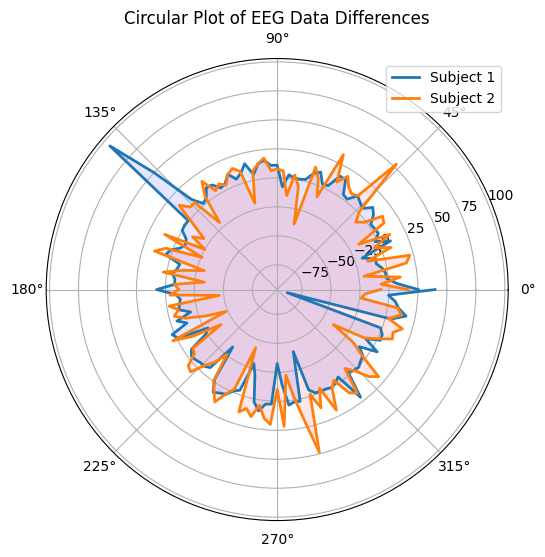

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing (you can adjust this based on your requirements)
# Assuming you want to compare mean values across each dimension
mean_eeg_data_asd1 = np.mean(eeg_data_asd[0], axis=1)
mean_eeg_data_asd2 = np.mean(eeg_data_asd[2], axis=1)

# Circular Plotting
theta = np.linspace(0, 2 * np.pi, len(mean_eeg_data_asd1))

plt.figure(figsize=(8, 6))
ax = plt.subplot(111, polar=True)
ax.plot(theta, mean_eeg_data_asd1, label='Subject 1', linewidth=2)
ax.plot(theta, mean_eeg_data_asd2, label='Subject 2', linewidth=2)
ax.fill(theta, mean_eeg_data_asd1, 'b', alpha=0.1)
ax.fill(theta, mean_eeg_data_asd2, 'r', alpha=0.1)
ax.legend()
plt.title('Circular Plot of EEG Data Differences')
plt.savefig('heterogenity.eps', format='eps')
plt.show()

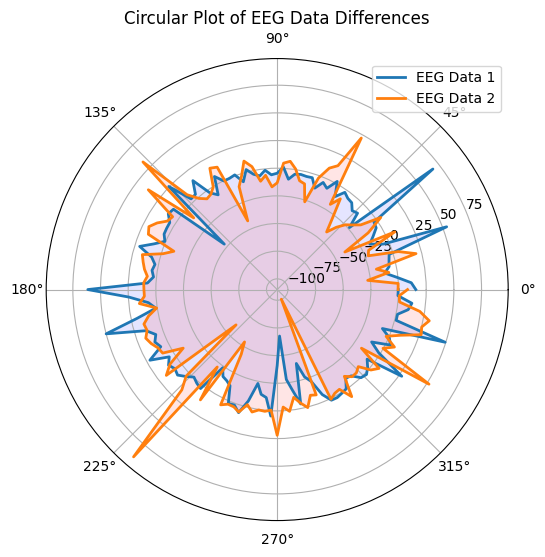

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing (you can adjust this based on your requirements)
# Assuming you want to compare mean values across each dimension
mean_eeg_data_asd1 = np.mean(eeg_data_asd[1], axis=1)
mean_eeg_data_asd2 = np.mean(eeg_data_asd[3], axis=1)

# Circular Plotting
theta = np.linspace(0, 2 * np.pi, len(mean_eeg_data_asd1))

plt.figure(figsize=(8, 6))
ax = plt.subplot(111, polar=True)
ax.plot(theta, mean_eeg_data_asd1, label='EEG Data 1', linewidth=2)
ax.plot(theta, mean_eeg_data_asd2, label='EEG Data 2', linewidth=2)
ax.fill(theta, mean_eeg_data_asd1, 'b', alpha=0.1)
ax.fill(theta, mean_eeg_data_asd2, 'r', alpha=0.1)
ax.legend()
plt.title('Circular Plot of EEG Data Differences')
plt.show()